In [2]:
import time
from multiprocessing import Pool

from IPython.display import display

from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from itertools import cycle
lstyle = cycle(('-', '--', ':', '-.',\
    (0, (1, 10)), (0, (5, 10)),\
    (0, (5, 5)), (0, (3, 10, 1, 10)),\
    (0, (3, 5, 1, 5)), \
    (0, (3, 5, 1, 5, 1, 5))))
color = cycle(('#1f77b4', '#ff7f0e', '#2ca02c',\
    '#d62728', '#9467bd', '#8c564b', '#e377c2',\
    '#7f7f7f', '#bcbd22', '#17becf'))


from scipy.sparse import *
from scipy.sparse.linalg import spsolve

**Kovasznay flow**

This is a classical Navier-Stokes problem, in general used to state the con-
vergence order of the considered formulae. Exact solution is
\begin{equation} \label{eq2}
\left\lbrace 
\begin{array}{l}
 u = 1-e^{\lambda x} \cos(2 \pi y) ,\\
 v = \frac{\lambda}{2\pi} e^{\lambda x} \sin(2 \pi y) ,\\
 p = p_0-\frac{1}{2}e^{2\lambda x} ,
\end{array}
\right. 
\end{equation} 
in $[-1.5, 1.5]\times[-2.5, 2]\times[0, 6]$, where $\lambda = \mathrm{Re}/2-\sqrt{\mathrm{Re}^2/4+4\pi^2}$.
We have set Reynolds number $\mathrm{Re}=40$, $p_0=1$ and $\tau=0.05h$.

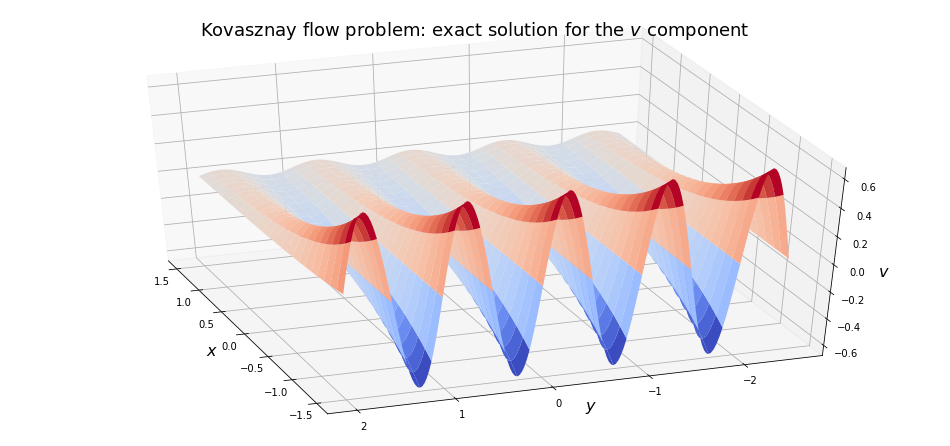

In [7]:
def kovasznay_flow(t, x, y, Re):
    p0 = 1.
    Lambda = Re/2.-sqrt(Re**2/4.+4*pi**2)
    return (1.-exp(Lambda*x)*cos(2.*pi*y),\
            Lambda/(2.*pi)*exp(Lambda*x)*sin(2.*pi*y),\
            p0-1./2*exp(2.*Lambda*x))

h, Re= 2.5e-2, 40.

x, y = meshgrid(arange(-1.5, 1.5, h, dtype=float64),\
                arange(-2.5, 2.0, h, dtype=float64), indexing='ij')
fig = figure(figsize=(13, 6))
axes = Axes3D(fig)
axes.plot_surface(x, y, kovasznay_flow(0., x, y, Re)[1],\
                  rstride=5, cstride=5, cmap=cm.coolwarm)
axes.set_xlabel(r"$x$", {'fontsize': 16})
axes.set_ylabel(r"$y$", {'fontsize': 16})
axes.set_zlabel(r"$v$", {'fontsize': 16})
axes.set_title(r"Kovasznay flow problem: exact solution for the $v$ component",\
               {'fontsize': 18})
axes.view_init(azim=160., elev=40.)
show()
# savefig('./kovasznay_flow_exact_v.pdf')
close()

**Taylor decaying**

This is a classical Navier-Stokes problem, in general used to state the con-
vergence order of the considered formulae. Exact solution is
\begin{equation} \label{eq1}
\left\lbrace 
\begin{array}{l}
 u = -e^{-2t/\mathrm{Re}} \cos(x) \sin(y) ,\\
 v =  e^{-2t/\mathrm{Re}} \sin(x) \cos(y) ,\\
 p = -e^{-4t/\mathrm{Re}} (\cos(2x) + \cos(2y))/4 ,
\end{array}
\right. 
\end{equation} 
in $[0, 2\pi]\times[0, 2\pi]\times[0, 1]$, where the Reynolds number $\mathrm{Re} = 10^{2}$, 
$\tau=0.05h$.

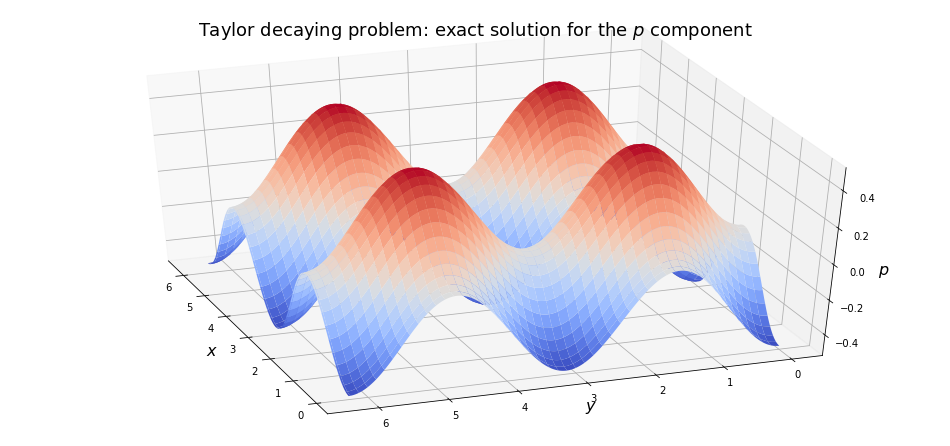

In [8]:
def taylor_decaying(t, x, y, Re):
    return (-exp(-2.*t/Re)*cos(x)*sin(y),
             exp(-2.*t/Re)*sin(x)*cos(y),
            -exp(-4.*t/Re)*(cos(2.*x)+cos(2.*y))/4.)

h, Re = 2.5e-2, 1.e2
x, y = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
                arange(0., 2.*pi, h, dtype=float64), indexing='ij')

fig = figure(figsize=(13, 6))
axes = Axes3D(fig)
axes.plot_surface(x, y, taylor_decaying(0., x, y, Re)[2], \
                  rstride=5, cstride=5, cmap=cm.coolwarm)
axes.set_xlabel(r"$x$", {'fontsize': 16})
axes.set_ylabel(r"$y$", {'fontsize': 16})
axes.set_zlabel(r"$p$", {'fontsize': 16})
axes.set_title(r"Taylor decaying problem: exact solution for the $p$ component",\
               {'fontsize': 18})
axes.view_init(azim=160., elev=40.)
show()
# savefig('./taylor_decaying_exact_p.pdf')
close()

\begin{equation}\label{1}
\left\lbrace 
\begin{array}{rl}
F^1:& u_x+v_y=0 ,\\[4pt]
F^2:& u_t + u u_x+v u_y + p_x -\frac{1}{\mathrm{Re}}\nabla^2 u = 0 ,\\[4pt]
F^3:& v_t + u v_x+v v_y + p_y - \frac{1}{\mathrm{Re}}\nabla^2 v = 0 .
\end{array}
\right. 
\end{equation} 

Пусть $p \succ u \succ v$ и $t \succ x \succ y$. Введем допустимое упорядочение таким способом, что
любая производная по $t$ старше любой другой производной, а затем сравниваем
для все равного какого допустимого упорядочения по *POT*.

Тогда лидирующими членами для системы выше будут соответственно $u_x,\, u_t,\, v_t$ 
и можно будет построить следующий $S$-полином:
\begin{equation}\label{2}
 \left(F^2_x -  F^1_t\right) + F^3_y + \frac{1}{\mathrm{Re}}\nabla^2 F^1
 = \left(uu_x+vu_y\right)_x + \left(u v_x+v v_y\right)_y + \nabla^2 p  .
\end{equation} 

В результате получим инволютивную систему:
\begin{equation}\label{3}
\left\lbrace 
\begin{array}{rl}
F^1:& u_x+v_y=0 ,\\[4pt]
F^2:& u_t + u u_x+v u_y + p_x -\frac{1}{\mathrm{Re}}\nabla^2 u = 0 ,\\[4pt]
F^3:& v_t + u v_x+v v_y + p_y - \frac{1}{\mathrm{Re}}\nabla^2 v = 0,\\[4pt]
F^4:& \left(uu_x+vu_y\right)_x + \left(u v_x+v v_y\right)_y + \nabla^2 p=0 ,
\end{array}
\right. 
\end{equation} 
где лидирующими членами будут соответственно $u_x,\, u_t,\, v_t,\, p_{xx}$.

Инволютивную систему можно переписать в виде законов сохранения:
\begin{equation}\label{3d}
\left\lbrace 
\begin{array}{rl}
F^1:& \operatorname{div}(u,\, v)=0 ,\\[4pt]
F^2:& u_t + \operatorname{div}\left(u^2+p-\frac{1}{\mathrm{Re}}u_x,\, vu -\frac{1}{\mathrm{Re}}u_y\right)=0 ,\\[4pt]
F^3:& v_t + \operatorname{div}\left(uv-\frac{1}{\mathrm{Re}}v_x,\, v^2+p -\frac{1}{\mathrm{Re}}v_y\right)=0,\\[4pt]
F^4:& \operatorname{div}\left(uu_x+vu_y+p_x,\, uv_x+vv_y+p_y\right)=0 .
\end{array}
\right. 
\end{equation} 

Построение простой итерации для полиномиалного вида $F(x)$
\begin{equation}
\begin{array}{l}
u^2 = u^2 - u'^2 + u'^2 = (u-u')(u+u') +
\\ \quad {} 
+u'^2 \approx (u-u') 2u' + u'^2= 2uu' - u'^2 \\
uv = (u+v)^2 - (u-v)^2)/4 \approx
((2(u+v)(u'+v') - (u'+v')^2) -
{} \hfill \\ \hfill {}
- (2(u-v)(u'-v') - (u'-v')^2))/4 = uv'+u'v-u'v' \\
u^3 = u^3 - u'^3 + u'^3 = (u-u')(u^{2} + u u' + u'^{2}) +
{} \hfill \\ \hfill {}
+u'^3 \approx (u-u') 3u'^2 + u'^2= 3uu'^2 - 2u'^3
\end{array}
\end{equation}

Пример общего правила (3 - полная степень):
\begin{equation}\label{ex1}
\begin{array}{l}
u^2 v = u u v \approx u' u' v + u u' v' + u' u v'-
{} \hfill \\ \hfill {}
- (3 - 1) u'^2v'= u'^2 v + 2uu'v' - 2u'^2v'
\end{array}
\end{equation}